INDIVIDUARE E TRATTARE I MISSING VALUES

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# importo il dataset
df = pd.read_csv("train.csv")

In [4]:
# creo una copia su cui lavorare mantenendo inalterato l'originale
dfm = df.copy()

In [5]:
# controllo missing values
dfm.isnull().sum()

name                         0
duration_ms                  0
explicit                     0
popularity                   0
artists                      0
album_name                   0
danceability                 0
energy                       0
key                          0
loudness                     0
mode                      4450
speechiness                  0
acousticness                 0
instrumentalness             0
liveness                     0
valence                      0
tempo                        0
features_duration_ms         0
time_signature            2062
n_beats                      0
n_bars                       0
popularity_confidence    12783
processing                   0
genre                        0
dtype: int64

Ci sono tre categorie che presentano missing values:
1) mode
2) time_signature
3) popularity_confidence

1) la strategia adottata per mode è quella di valutare le frequenze di occorrenza di 0 e 1 per ogni genre, ed utilizzarle come probabilità per estrarre i valori (0,1) da sostituire ai missing values
2) la strategia adottata per time_signature è di sostituire i missing values con la moda
3) la strategia adottata per popularity_confidence è quella di eliminare la colonna

TIME_SIGNATURE

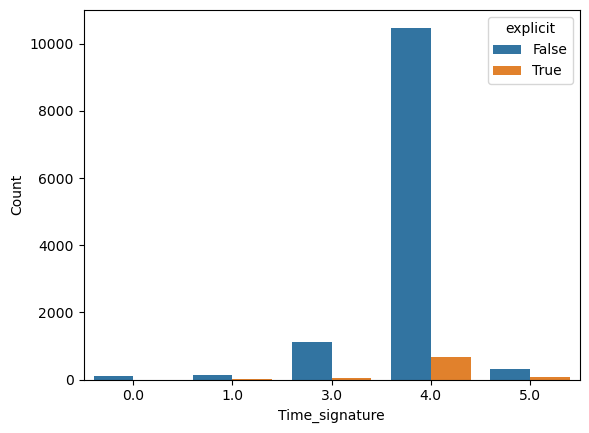

In [6]:
# vediamo come si presenta
sns.countplot(data=df, x="time_signature", hue="explicit")
plt.ylabel('Count')
plt.xlabel('Time_signature')
plt.show()

In [7]:
dfm['time_signature'].describe()

count    12938.000000
mean         3.876179
std          0.566491
min          0.000000
25%          4.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: time_signature, dtype: float64

In [8]:
# notiamo che l'andamento è fortemente orientato verso i valore 4, tanto che si ha una media di 3.876179
# quello che facciamo è quindi sostituire i valori mancanti con la moda

In [9]:
dfm['time_signature'].mode()[0]

4.0

In [10]:
dfm['time_signature'] = dfm['time_signature'].fillna(dfm['time_signature'].mode()[0])

In [11]:
# controllo di aver riempito
dfm['time_signature'].describe()

count    15000.000000
mean         3.893200
std          0.527837
min          0.000000
25%          4.000000
50%          4.000000
75%          4.000000
max          5.000000
Name: time_signature, dtype: float64

In [12]:
dfm.isnull().sum()

name                         0
duration_ms                  0
explicit                     0
popularity                   0
artists                      0
album_name                   0
danceability                 0
energy                       0
key                          0
loudness                     0
mode                      4450
speechiness                  0
acousticness                 0
instrumentalness             0
liveness                     0
valence                      0
tempo                        0
features_duration_ms         0
time_signature               0
n_beats                      0
n_bars                       0
popularity_confidence    12783
processing                   0
genre                        0
dtype: int64

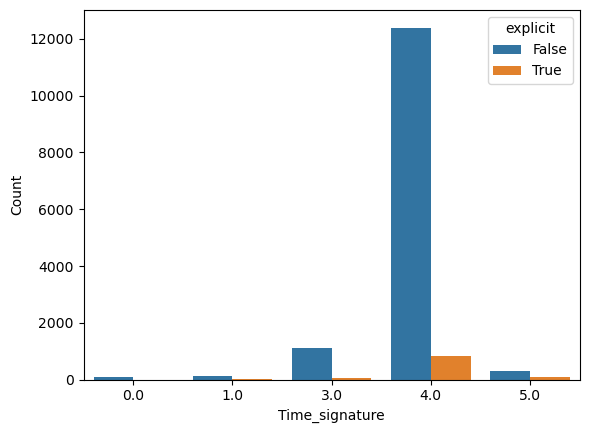

In [13]:
# valuto come cambia il bar plot dopo il riempimento
sns.countplot(data=dfm, x="time_signature", hue="explicit")
plt.ylabel('Count')
plt.xlabel('Time_signature')
plt.show()

In [14]:
# comportamento qualitativo mantenuto

MODE

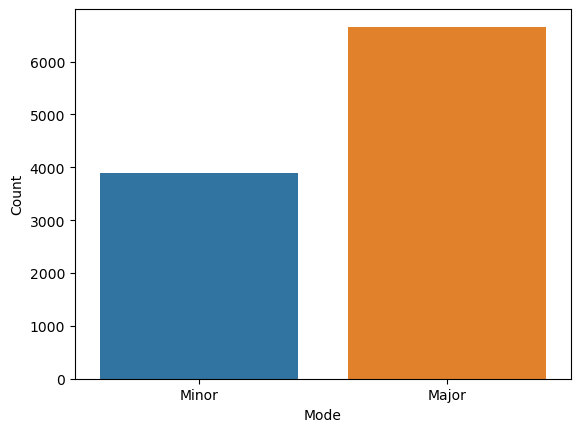

In [15]:
# valutiamo come si presenta
sns.countplot(data=dfm, x="mode")
plt.ylabel('Count')
plt.xlabel('Mode')
plt.xticks([0, 1], ['Minor', 'Major'], rotation=0)
plt.show()

In [16]:
# si nota una prevalenza di 1, ma vediamo come si presenta in base al genere

In [17]:
# vediamo il numero di missing values per genere
dfm.groupby('genre')['mode'].apply(lambda x: x.isnull().sum())

genre
afrobeat         219
black-metal      229
bluegrass        220
brazil           225
breakbeat        207
chicago-house    196
disney           221
forro            229
happy            224
idm              230
indian           231
industrial       244
iranian          227
j-dance          218
j-idol           226
mandopop         226
sleep            228
spanish          235
study            215
techno           200
Name: mode, dtype: int64

In [18]:
# ed il conseguente numero di valori non missing
dfm.groupby('genre')['mode'].count()

genre
afrobeat         531
black-metal      521
bluegrass        530
brazil           525
breakbeat        543
chicago-house    554
disney           529
forro            521
happy            526
idm              520
indian           519
industrial       506
iranian          523
j-dance          532
j-idol           524
mandopop         524
sleep            522
spanish          515
study            535
techno           550
Name: mode, dtype: int64

In [19]:
# creiamo il dataframe df1 senza missing values di mode e vediamo che rapporto c'è tra le occorrenze di 1 e 0
df1 = dfm[dfm['mode'].notnull()]
df1.groupby('genre')['mode'].value_counts(normalize=True).unstack() 

mode,0.0,1.0
genre,,
afrobeat,0.440678,0.559322
black-metal,0.428023,0.571977
bluegrass,0.166038,0.833962
brazil,0.327619,0.672381
breakbeat,0.412523,0.587477
chicago-house,0.485560,0.514440
disney,0.247637,0.752363
forro,0.341651,0.658349
happy,0.368821,0.631179


In [20]:
# notiamo che i rapporti tra 0 e 1 occorrono con frequenze diverse a seconda del genere, quindi se vogliamo sostituire i valori nulli tenendo conto di ciò, possiamo agire come segue:

In [21]:
# crea un df con due colonne genre e n. di missing values per ogni genre, ed aggiunge l'indice alle righe
missing_counts = dfm.groupby('genre')['mode'].apply(lambda x: x.isnull().sum()).reset_index()

# rinomino le colonne del df missing_counts, che orasi chiameranno genre e missing_count invece che genre e mode
missing_counts.columns = ['genre', 'missing_count']

# Crea il DataFrame df1 privo di missing values
df1 = dfm[dfm['mode'].notnull()]

# Calcola le frequenze di 0 e 1 per ciascun genere in df1
# frequencies_by_genre è un df che contiene le frequenze di 0 e 1 per ciascun genere
frequencies_by_genre = df1.groupby('genre')['mode'].value_counts(normalize=True).unstack().fillna(0)

# Sostituisci i missing values con liste di 0 e 1 basate sulle frequenze per ogni genere
for genre in dfm['genre'].unique():
    # restituisce True se c'è un missing value in mode e se è il genere in questione
    missing_values = dfm['mode'].isnull() & (dfm['genre'] == genre)
    # seleziona la giusta riga e colonna del df missing_counts e restituisce il conteggio di missing values per quel genre
    missing_count = missing_counts[missing_counts['genre'] == genre]['missing_count'].values[0]

    if missing_count > 0:
        # retituisce la coppia di frequenze per i valori 0 e 1 per il genre in questione
        frequencies = frequencies_by_genre.loc[genre]
        # crea un array di 0 e 1 estratti in base alle frequenze del genere, utilizzate come probabilità
        replacement_values = np.random.choice([0, 1], size=missing_count, p=frequencies)
        # sostituisce i missing values (True) della colonna mode con i valori dell'array precedente
        dfm.loc[missing_values, 'mode'] = replacement_values

In [22]:
# controlliamo che i rapporti tra le occorrenze rimangano simili a quelli di partenza

In [23]:
dfm.groupby('genre')['mode'].value_counts(normalize=True).unstack().fillna(0)

mode,0.0,1.0
genre,,
afrobeat,0.464000,0.536000
black-metal,0.430667,0.569333
bluegrass,0.162667,0.837333
brazil,0.321333,0.678667
breakbeat,0.413333,0.586667
chicago-house,0.466667,0.533333
disney,0.242667,0.757333
forro,0.342667,0.657333
happy,0.384000,0.616000


In [24]:
# controlliamo di avere 750 canzoni per genere(quindi nessun miss value)
dfm.groupby('genre')['mode'].count()

genre
afrobeat         750
black-metal      750
bluegrass        750
brazil           750
breakbeat        750
chicago-house    750
disney           750
forro            750
happy            750
idm              750
indian           750
industrial       750
iranian          750
j-dance          750
j-idol           750
mandopop         750
sleep            750
spanish          750
study            750
techno           750
Name: mode, dtype: int64

In [25]:
# altra prova
dfm.isnull().sum()

name                         0
duration_ms                  0
explicit                     0
popularity                   0
artists                      0
album_name                   0
danceability                 0
energy                       0
key                          0
loudness                     0
mode                         0
speechiness                  0
acousticness                 0
instrumentalness             0
liveness                     0
valence                      0
tempo                        0
features_duration_ms         0
time_signature               0
n_beats                      0
n_bars                       0
popularity_confidence    12783
processing                   0
genre                        0
dtype: int64

POPULARITY_CONFIDENCE

In [26]:
# in questo caso i missing values sono più dell'85 per 100 del totale, quindi la decisione è quella di eliminare la colonna
dfm.isnull().sum()

name                         0
duration_ms                  0
explicit                     0
popularity                   0
artists                      0
album_name                   0
danceability                 0
energy                       0
key                          0
loudness                     0
mode                         0
speechiness                  0
acousticness                 0
instrumentalness             0
liveness                     0
valence                      0
tempo                        0
features_duration_ms         0
time_signature               0
n_beats                      0
n_bars                       0
popularity_confidence    12783
processing                   0
genre                        0
dtype: int64

In [27]:
dfm = dfm.drop('popularity_confidence', axis=1)

In [28]:
dfm.isnull().sum()

name                    0
duration_ms             0
explicit                0
popularity              0
artists                 0
album_name              0
danceability            0
energy                  0
key                     0
loudness                0
mode                    0
speechiness             0
acousticness            0
instrumentalness        0
liveness                0
valence                 0
tempo                   0
features_duration_ms    0
time_signature          0
n_beats                 0
n_bars                  0
processing              0
genre                   0
dtype: int64

Il dataframe dfm è il risultato della sostituzione dei missing values

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns

In [31]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
import seaborn as sns
from scipy.spatial.distance import pdist, squareform

In [32]:
from sklearn.metrics import *
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.neighbors import kneighbors_graph

In [38]:
# rimuovo le variabili categoriche
dfk = dfm.drop(['name', 'artists', 'album_name', 'genre'], axis=1)
# rimuovo le variabili binary ed ordinal
dfk.drop(['explicit', 'mode', 'key', 'time_signature'], axis=1, inplace=True)
dfk.dtypes

duration_ms               int64
popularity                int64
danceability            float64
energy                  float64
loudness                float64
speechiness             float64
acousticness            float64
instrumentalness        float64
liveness                float64
valence                 float64
tempo                   float64
features_duration_ms      int64
n_beats                 float64
n_bars                  float64
processing              float64
dtype: object

In [36]:
dbscan = DBSCAN(eps=0.3, min_samples=5, metric='euclidean')
dbscan.fit(dfk)

hist, bins = np.histogram(dbscan.labels_, bins=range(-1, len(set(dbscan.labels_)) + 1))
print('labels', dict(zip(bins, hist)))
print('silhouette', silhouette_score(dfm[dbscan.labels_ != -1], dbscan.labels_[dbscan.labels_ != -1]))

labels {-1: 15000, 0: 0}


ValueError: Found array with 0 sample(s) (shape=(0, 23)) while a minimum of 1 is required.